# sscan as 1D Flyer

<font color="red">NOTE</font>: This notebook is under construction!

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for [bluesky](http://nsls-ii.github.io/bluesky) data acquisition.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

Suggest the _noisy v m1_ scan, done as 1-D step scan with sscan record.  noisy is the swait record calculating a peak based on m1 position.

In [1]:
%matplotlib notebook

import os, pathlib, sys
sys.path.append(os.path.abspath(os.path.join(pathlib.Path.home(), "bluesky")))
from instrument.collection import *

I Sat-23:31:08 - ############################################################ startup
I Sat-23:31:08 - logging started
I Sat-23:31:08 - logging level = 10
I Sat-23:31:08 - /home/prjemian/bluesky/instrument/collection.py
I Sat-23:31:08 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Sat-23:31:08 - #### Bluesky Framework ####
I Sat-23:31:08 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Sat-23:31:08 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Sat-23:31:09 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Sat-23:31:10 - using databroker catalog 'training'
I Sat-23:31:10 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Sat-23:31:10 - #### Devices ####
I Sat-23:31:10 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Sat-23:31:10 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Sat-23:31:12 - /home/prjemian/bluesky/instrument/devices/ioc_stats.py
I Sat-23:31:12 - /home/prjemian/bluesky/instrument/devices/motors.py
I Sat-23:31:12 - /home/prjemian/bluesky/instrument/devices/noisy_detector.py
I Sat-23:31:12 - /home/prjemian/bluesky/instrument/devices/scaler.py
I Sat-23:31:13 - /home/prjemian/bluesky/instrument/devices/shutter_simulator.py
I Sat-23:31:13 - /home/prjemian/bluesky/instrument/devices/temperature_signal.py
I Sat-23:31:13 - #### Callbacks ####
I Sat-23:31:13 - /home/prjemian/bluesky/instrument/callbacks/spec_data_file_writer.py
I Sat-23:31:14 - writing to SPEC fi

In [2]:
# add this notebook's name to the metadata

RE.md["notebook"] = "sscan_1d_flyer"

In [3]:
# define the IOC's prefix

ioc = "gp:"

## Bluesky step scan

We are told that the `noisy` signal will show a peak when `m1` is moved over the range `[-1 .. +1]`.  Use *bluesky* to show that peak.



Transient Scan ID: 313     Time: 2021-09-04 23:31:14
Persistent Unique Scan ID: '7247c37a-5c5a-41c4-b42c-93e643f510d5'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 23:31:16.7 |   -1.10000 |  999.09088 |
|         2 | 23:31:17.1 |   -0.99000 | 1144.58408 |
|         3 | 23:31:17.5 |   -0.88000 | 1495.48714 |
|         4 | 23:31:17.9 |   -0.77000 | 1860.67587 |
|         5 | 23:31:18.3 |   -0.66000 | 2484.27244 |
|         6 | 23:31:18.7 |   -0.55000 | 3225.86197 |
|         7 | 23:31:19.1 |   -0.44000 | 4743.17255 |
|         8 | 23:31:19.5 |   -0.33000 | 7764.52017 |
|         9 | 23:31:19.9 |   -0.22000 | 13343.76724 |
|        10 | 23:31:20.3 |   -0.11000 | 28160.54394 |
|        11 | 23:31:20.7 |    0.00000 | 68850.85010 |
|        12 | 23:31:21.1 |    0.11000 | 84350.86770 |
|        13 | 23:31:21.5 |    0.220

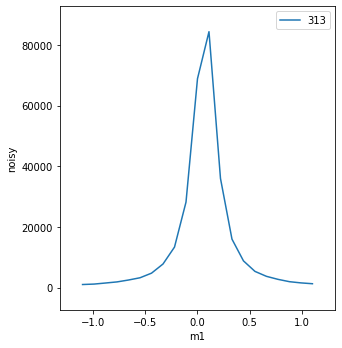

In [4]:
if True:
    # show a pre-assembled bluesky.plans.scan() acquisition
    RE(bp.scan([noisy], m1, -1.1, 1.1, 21))

## sscan as Bluesky Flyer

In [5]:
from ophyd import DeviceStatus, Signal
from ophyd.flyers import FlyerInterface
from apstools.synApps import SscanRecord

<details>
<summary>if save data is to be used</summary>

```python
# TODO: if save data is to be used

# # configure saveData for data collection into MDA files:
# save_data.stage_sigs["file_system"] = "/tmp"
# save_data.stage_sigs["subdirectory"] = "saveData"
# save_data.stage_sigs["base_name"] = "sscan1_"
# save_data.stage_sigs["next_scan_number"] = 1
# save_data.stage_sigs["comment1"] = "testing"
# save_data.stage_sigs["comment2"] = "configured and run from ophyd"
```

</details>

----------------

In [6]:
class SscanFlyer_1D_StepSimple(FlyerInterface, SscanRecord):

    def __init__(self, *args, **kwargs):
        self._acquiring = False

        super().__init__(*args, **kwargs)

    def stage(self):
        self.select_channels()
        super().stage()

    def unstage(self):
        super().unstage()
        self.select_channels()

    def setup_staging_1D_step(self, start=-1.1, finish=1.1, num=21, ddelay=0.01, pdelay=0):
        # configure sscan record for 1D step scan: noisy v. m1
        self.xref = dict(
            raw_positioners=[m1, ],
            positioners=[m1, ],
            raw_detectors=[noisy, ],
            detectors=[noisy, m1.user_setpoint]  # include motor setpoints array
        )
        self.stage_sigs["number_points"] = num
        self.stage_sigs["pasm"] = "PRIOR POS"
        self.stage_sigs["positioner_delay"] = pdelay
        for i, p in enumerate(self.xref["raw_positioners"]):
            self.stage_sigs[f"positioners.p{i+1}.setpoint_pv"] = p.user_setpoint.pvname
            self.stage_sigs[f"positioners.p{i+1}.readback_pv"] = p.user_readback.pvname
            self.stage_sigs[f"positioners.p{i+1}.start"] = start
            self.stage_sigs[f"positioners.p{i+1}.end"] = finish
        self.stage_sigs["detector_delay"] = ddelay
        for i, d in enumerate(self.xref["detectors"]):
            self.stage_sigs[f"detectors.d{i+1:02d}.input_pv"] = d.pvname

        # get timestamp of each point in the scan
        # This is a sscan record trick that returns the time (s) since the scan started.
        self.stage_sigs[f"positioners.p4.readback_pv"] = "time"

    def read_configuration(self):
        return {}

    def describe_configuration(self):
        return {}

    def kickoff(self):
        self.setup_staging_1D_step()

        # set(), do not `yield`, in kickoff()
        self.execute_scan.set(1)  # start the sscan record
        self._acquiring = True

        status = DeviceStatus(self)
        status.set_finished()  # means that kickoff was successful
        return status

    def complete(self):
        """Wait for sscan to complete."""
        logging.info("complete() starting")
        if not self._acquiring:
            raise RuntimeError("Not acquiring")

        st = DeviceStatus(self)
        cb_started = False

        def execute_scan_cb(value, timestamp, **kwargs):
            value = int(value)
            if cb_started and value == 0:
                logging.info("complete() ending")
                self.unstage()
                self._acquiring = False
                self.execute_scan.unsubscribe(execute_scan_cb)
                if not st.done:
                    logging.info("Setting %s execute status to `done`.", self.name)
                    st.set_finished()

        self.execute_scan.subscribe(execute_scan_cb)
        # self.execute_scan.set(1)
        cb_started = True
        return st

    def describe_collect(self):
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
        # Provide schema & meta-data from collect()
        dd = {}
        dd.update(m1.describe())
        dd.update(noisy.describe())
        return {self.name: dd}

    def collect(self):
        """Retrieve all collected data (after complete())."""
        if self._acquiring:
            raise RuntimeError("Acquisition still in progress. Call complete() first.")
        # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
        # Retrieve data from the flyer as proto-events
        
        def get_data_from_sscan(obj, n):
            data = obj.read()[obj.name]
            data["value"] = list(data["value"][:n])
            return data

        def mkdoc(seq_num, values):
            timestamp = values.pop("__ts__")
            yield dict(
                seq_num=seq_num,
                time=timestamp,
                data={k: v for k, v in values.items()},
                timestamps={k: timestamp for k in values},
            )

        def read_sscan_data(scan):
            _cp = scan.current_point.read()[scan.current_point.name]
            n = _cp["value"]
            ts_last_point = _cp["timestamp"]

            # get the per-step time stamps from positioner 4
            ts_arr = self.positioners.p4.array.get(use_monitor=False)[:n]
            ts_arr = ts_last_point + ts_arr - ts_arr.max()

            results = dict(__ts__=list(ts_arr))

            # This gets the full array for each item in one document
            for category, signals in scan.xref.items():
                for i, signal in enumerate(signals):
                    if category == "positioners":
                        item = f"p{i+1}"
                    elif category == "detectors":
                        item = f"d{i+1:02d}"
                    else:
                        continue
                    data = get_data_from_sscan(getattr(scan, f"{category}.{item}.array"), n)
                    results[signal.name] = data["value"]

            for i in range(n):
                yield from mkdoc(i+1, {k: results[k][i] for k in results})

        yield from read_sscan_data(self)
        # self.unstage()

In [7]:
flyer = SscanFlyer_1D_StepSimple(f"{ioc}scan1", name="flyer")
flyer.wait_for_connection()  # sscan records have _many_ channels and fields
flyer.reset()  # clear out any previous configuration

In [8]:
import yaml, json, pprint, datetime

def doc_printer(key, doc):
    print(key, len(doc))
    # if key in ("descriptor", "bulk_events"):
    #     # print(yaml.dump(doc), sys.stdout)
    #     # print(json.dumps(doc))
    pprint.pprint(doc)

import bluesky
_RE = bluesky.RunEngine({})
_RE.subscribe(doc_printer)

0

In [9]:
flyer.setup_staging_1D_step(num=71)
flyer.select_channels()

flyer.unstage()
flyer.stage()

RE(bp.fly([flyer]))
flyer.unstage()



Transient Scan ID: 314     Time: 2021-09-04 23:31:27
Persistent Unique Scan ID: '80aa2128-28a1-4b84-be4d-c0082c225179'
New stream: 'baseline'
New stream: 'flyer'


/home/prjemian/.local/lib/python3.8/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


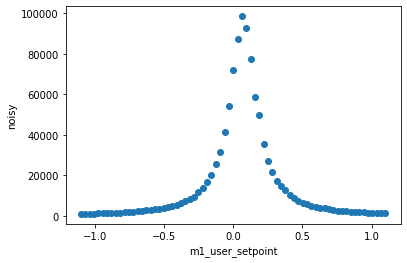

In [10]:
run = cat[-1]
data = run.flyer.read()
data.plot.scatter("m1_user_setpoint", "noisy")